# Startpoint compare concoa to observations. 
**To run this script:**
First run [create_concoa.ipynb](create_concoa.ipynb) to compute concoa. The module 'read_CMIP.py' should be in the same folder as this notebook.
This field is calculated assuming surface pressure and temperature is good enough for the values in the gridbox.
The cmip6 data is in mass mixing ratio (mmroa) kg/kg. The aerocom variable is in $\mu g/m3$.

$$mmr \cdot \rho_{air} \cdot 10^9 = concoa$$

because

$$ [kg/kg_{air}] \cdot [kg_{air}/m^3] \cdot [\mu g][kg] = [\mu g/m^3] $$

We calculate $\rho_{air}$ by the ideal gas equation:
$$\rho_{air} = RT/p$$
where $\rho_{air}$ is the air density, $R$ is the gas constant for dry air and $p$ is the pressure. 

In [2]:
import sys
sys.path.append('negi-stuff/')
import pyaerocom as pya
from warnings import filterwarnings
filterwarnings('ignore')
pya.__version__

from negi_stuff.modules.make_folders import make_folders 
from negi_stuff.modules.imps import *
import read_CMIP
from read_CMIP import make_folders

/opt/conda/lib/python3.7/site-packages/geonum/__init__.py:39: UserWarning: Plotting of maps etc. is deactivated, please install Basemap
  warn('Plotting of maps etc. is deactivated, please install Basemap')


Loading BokehJS ...

### Define what we want to load:

In [3]:
models = ['NorESM2-LM', 'UKESM1-0-LL'] # models we are using
concoa = 'concoa' # variable. 
experiment='historical'
s_y = 1980 # start year
e_y = 2014 # end year


### Step 1: Read the model data into pyaerocom
The code below reads the calculated concoa file into pyaerocom. It then makes a list with the two gridded data objects for convenience. It also gives the data_id the right name.

In [4]:
modeldata_l =[]
for model in models:
    # This line finds the filename of the concoa file for the specified model. 
    path_concoa = 'computed_fields/' + read_CMIP.calc_filen(model, concoa, s_y, e_y, experiment, lev=0) 
    print('Loading file: %s'%path_concoa)
    _md=pya.GriddedData(path_concoa, var_name='concoa') # read model file with pyaerocom GriddedData
    _md.metadata['ts_type'] = 'monthly' # needed for colocation
    _md.metadata['data_id'] = model # Set right data_id (avoid n/d)
    modeldata_l.append(_md)# Add object to list.
    

Loading file: computed_fields/NorESM2-LM/concoa_1980_2014_historical_lev0.nc
Loading file: computed_fields/UKESM1-0-LL/concoa_1980_2014_historical_lev0.nc


In [5]:
import pyaerocom as pya

### Step 2: Read in observations


Set base dir for observations:

In [8]:
pya.const.BASEDIR = '/home/notebook/shared-ns1000k/inputs/pyaerocom-testdata/'

Initiating directories for pyaerocom test dataset


In [9]:
obsdata = pya.io.ReadUngridded().read('EBASMC',vars_to_retrieve='concoa', lat_range=[60, 90]) # choose stations above 60 degrees

Received additional reading constraints, ignoring caching
Retrieving EBAS files for variables
['concoa']
Reading files 1-5 of 45 (ReadEbas) | 21:01:10 (delta = 0 s')
Reading files 5-9 of 45 (ReadEbas) | 21:01:10 (delta = 0 s')
Reading files 9-13 of 45 (ReadEbas) | 21:01:10 (delta = 0 s')
Reading files 13-17 of 45 (ReadEbas) | 21:01:10 (delta = 0 s')
Reading files 17-21 of 45 (ReadEbas) | 21:01:10 (delta = 0 s')
Reading files 21-25 of 45 (ReadEbas) | 21:01:10 (delta = 0 s')
Reading files 25-29 of 45 (ReadEbas) | 21:01:11 (delta = 0 s')
Reading files 29-33 of 45 (ReadEbas) | 21:01:11 (delta = 0 s')
Reading files 33-37 of 45 (ReadEbas) | 21:01:11 (delta = 0 s')
Reading files 37-41 of 45 (ReadEbas) | 21:01:11 (delta = 0 s')
Reading files 41-45 of 45 (ReadEbas) | 21:01:11 (delta = 0 s')
Reading files 45-49 of 45 (ReadEbas) | 21:01:11 (delta = 0 s')


### Plot the observation locations

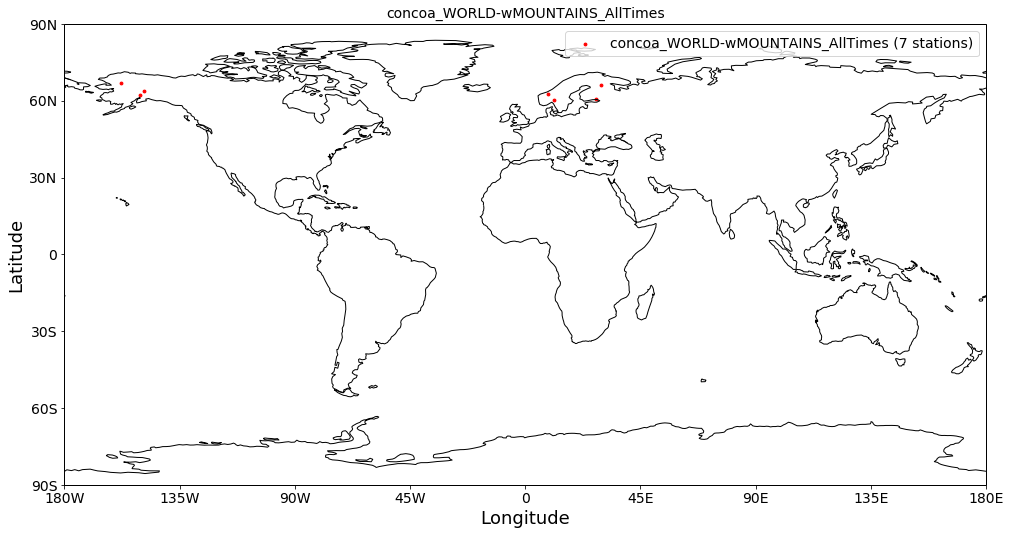

In [12]:
obsdata.plot_station_coordinates(var_name='concoa')#, start=2010, markersize=50);

In [16]:
obsdata.unique_station_names

['Ambler',
 'Denali National Park-Mt. McKinley (AK03)',
 'Hurdal',
 'Kårvatn',
 'Oulanka',
 'Trapper Creek',
 'Virolahti II']

### Example observation site

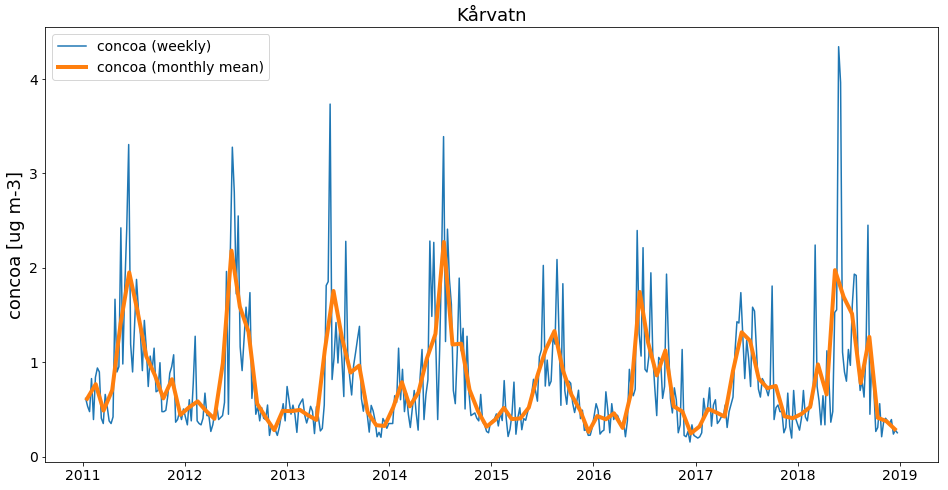

In [11]:
station = obsdata.to_station_data('Kårvatn')
ax = station.plot_timeseries('concoa')
ax = station.plot_timeseries('concoa', freq='monthly', lw=4, ax=ax)

In [6]:
import matplotlib.pylab as plt#from negi_stuff.modules.imps import *

### Step 3: Collocate the data
Here we do the collocation

In [11]:
coldata_l = [] # list to hold the colocated data 
spath_base = 'coldata/' # where to save the colocated datasets
for model, modeldata in zip(models, modeldata_l): # loop over model name ('model') and modeldata pyaerocom ('modeldata')
    #modeldata.metadata['data_id'] = model 
    # colocate the model data with the observations:
    coldata = pya.colocation.colocate_gridded_ungridded(modeldata, obsdata, ts_type='monthly', start=2010)
    coldata_l.append(coldata) # add the coldata to a list 
    savepath = spath_base + read_CMIP.calc_filen(model, concoa, s_y, e_y, experiment, lev=0)  # savepath for the data
    make_folders(savepath) # makes the folders (if not already made) for the specified path
    coldata.data = read_CMIP.clean_ds_for_save(coldata.data) # Does some clean up in attributes to make it savable in netcdf 
    coldata.data.to_netcdf(savepath) # save data

Setting concoa outlier lower lim: -8999999999999999897486646837248.00
Setting concoa outlier upper lim: 8999999999999999897486646837248.00
Interpolating data of shape (60, 96, 144). This may take a while.
Successfully interpolated cube
Setting concoa outlier lower lim: -8999999999999999897486646837248.00
Setting concoa outlier upper lim: 8999999999999999897486646837248.00
Interpolating data of shape (60, 144, 192). This may take a while.
Successfully interpolated cube


### Make an xarray with both the models and the two datasets in one

In [12]:
ds_merge_coldata = xr.merge([coldata.data for coldata in coldata_l]) # merges the xarray.DataArrays 

### Save the colocated xarray dataset (so we don't need to make it again)

In [13]:
filep_coldata='%s_UKESM_NORESM_coldata_%s-%s.nc'%(concoa, s_y, e_y)

ds_merge_coldata.to_netcdf(filep_coldata)
ds_merge_coldata.close()

### Step 4: Open the file to work on it (If you've done the steps above before, you can skip directly here) 

In [14]:
ds_merge_coldata = xr.open_dataarray(filep_coldata)

In [15]:
import matplotlib.pyplot as plt

### Quick look at the data:

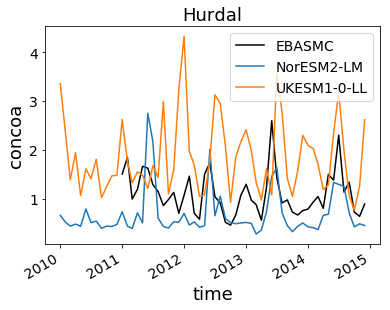

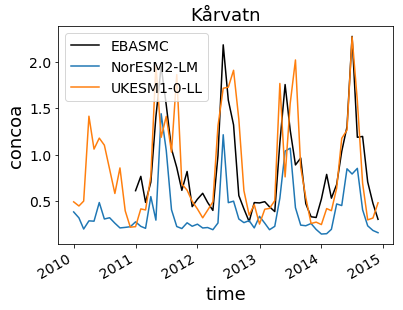

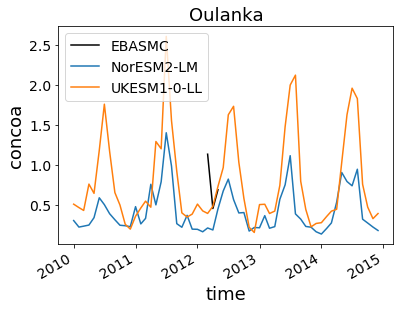

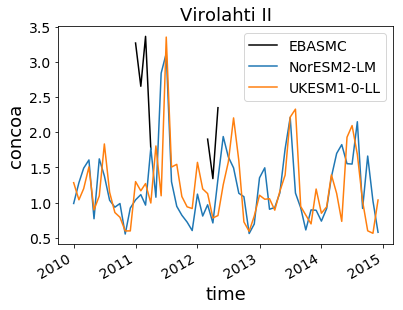

In [16]:
for station_name in ds_merge_coldata.station_name:
    ds_merge_coldata.sel(station_name=station_name).isel(data_source=0).plot(label=ds_merge_coldata.data_source[0].values, c='k')
    ds_merge_coldata.sel(station_name=station_name).isel(data_source=1).plot(label=ds_merge_coldata.data_source[1].values)
    ds_merge_coldata.sel(station_name=station_name).isel(data_source=2).plot(label=ds_merge_coldata.data_source[2].values)
    plt.title(station_name.values)
    plt.legend()
    plt.show()

### Step 5: For this step you need to have actually done the steps above 

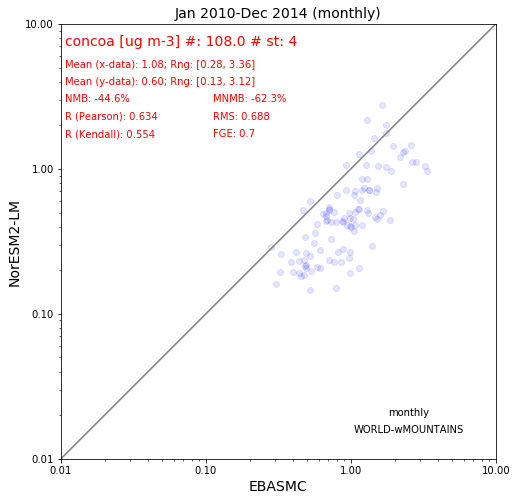

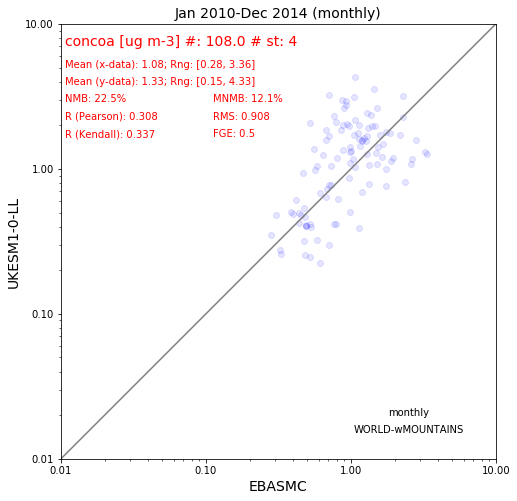

In [92]:
for coldata in coldata_l:
    coldata.plot_scatter(marker='o', color='blue', alpha=0.1);

In [101]:
coldata.calc_statistics()

{'totnum': 240.0,
 'num_valid': 108.0,
 'refdata_mean': 1.0841046310683824,
 'refdata_std': 0.6277714667369105,
 'data_mean': 1.3282478439311187,
 'data_std': 0.8332073621821118,
 'rms': 0.9084209288020547,
 'R': 0.3084794268880997,
 'R_spearman': 0.5210817762985359,
 'R_kendall': 0.33740155210084105,
 'nmb': 0.22520262884785738,
 'mnmb': 0.12140812539314293,
 'fge': 0.4684376479000297,
 'num_neg_data': 0,
 'num_neg_refdata': 0,
 'num_coords_with_data': 4,
 'num_coords_tot': 4}